## Compare track cuts 

Cuts required:

640 < t_0 < 1650 ns 


In [1]:
import uproot
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
plt.style.use("/exp/mu2e/data/users/sgrant/mu2e.mplstyle")
import numpy as np
import hist
import gc
import sys
from datetime import datetime

from pyutils.pyprocess import Processor, Skeleton
from pyutils.pyplot import Plot
from pyutils.pyprint import Print
from pyutils.pyselect import Select
from pyutils.pyvector import Vector

sys.path.append("../common")
from cut_manager import CutManager
from analyse import Analyse, Utils
from postprocess import PostProcess

# Process data

In [2]:
# from postprocess import PostProcesss

In [3]:
# Create your custom processor class
class CosmicProcessor(Skeleton):
    """Your custom file processor 
    
    This class inherits from the Skeleton base class, which provides the 
    basic structure and methods withing the Processor framework 
    """
    def __init__(self, file_name=None, file_list_path=None, defname=None, location=None):
        """Initialise your processor with specific configuration
        
        This method sets up all the parameters needed for this specific analysis.
        """
        # Call the parent class's __init__ method first
        # This ensures we have all the base functionality properly set up
        super().__init__()

        self.file_name = file_name 
        self.defname = defname
        self.file_list_path = file_list_path
        
        self.branches = { 
            "evt" : [
                "run",
                "subrun",
                "event",
            ],
            "crv" : [
                "crvcoincs.time",
                "crvcoincs.nHits",
                "crvcoincs.pos.fCoordinates.fZ"
            ],
            "trk" : [
                "trk.nactive", 
                "trk.pdg", 
                "trkqual.valid",
                "trkqual.result"
            ],
            "trkfit" : [
                "trksegs",
                "trksegpars_lh"
            ],
            "trkmc" : [
                "trkmcsim"
            ]
        }
        self.use_remote = True     # Use remote file via mdh
        self.location = location   # File location
        self.max_workers = 50      # Limit the number of workers
        self.verbosity = 2         # Set verbosity 
        self.use_processes = True  # Use processes rather than threads
        
        # Now add your own analysis-specific parameters 

        # Init analysis methods
        # Would be good to load an analysis config here 
        self.analyse = Analyse(
            # event_subrun=(93561, 25833), # select one event
            on_spill=True,
            verbosity=0
        )

        # Toggle cuts
        self.cuts_to_toggle = {
            "is_truth_electron" : True,
            "is_reco_electron" : True,
            "one_reco_electron" : False,
            "downstream" : False,
            "good_trkqual" : True,
            "has_hits" : False,
            "within_lhr_max" : False,
            "within_d0" : False,
            "within_pitch_angle" : False,
            "unvetoed" : False
        }

        self.veto = False # super ugly
            
        # Custom prefix for log messages from this processor
        self.print_prefix = "[CosmicProcessor] "
        print(f"{self.print_prefix}Initialised")
    
    # ==========================================
    # Define the core processing logic
    # ==========================================
    # This method overrides the parent class's process_file method
    # It will be called automatically for each file by the execute method
    def process_file(self, file_name): 
        """Process a single ROOT file
        
        This method will be called for each file in our list.
        It extracts data, processes it, and returns a result.
        
        Args:
            file_name: Path to the ROOT file to process
            
        Returns:
            A tuple containing the histogram (counts and bin edges)
        """
        try:
            # Create a local pyprocess Processor to extract data from this file
            # This uses the configuration parameters from our class
            this_processor = Processor(
                use_remote=self.use_remote,     # Use remote file via mdh
                location=self.location,         # File location
                verbosity=0 # self.verbosity        # Reduce output in worker threads
            )
            
            # Extract the data 
            this_data = this_processor.process_data(
                file_name = file_name, 
                branches = self.branches
            )
            
            # ---- Analysis ----            
            results = self.analyse.execute(
                this_data, 
                file_name,
                cuts_to_toggle = self.cuts_to_toggle,
                veto = self.veto
                
            )

            # Clean up
            gc.collect()

            return results 
        
        except Exception as e:
            # Handle any errors that occur during processing
            print(f"{self.print_prefix}Error processing {file_name}: {e}")
            return None



In [4]:
# Execute analysis
cosmic_processor = CosmicProcessor(
     # "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/data/nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.001202_00012335.root"
    # defname = "nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.root",
    file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.0_99.txt",
    location = "disk"
)
    
onspill_results = cosmic_processor.execute()

cosmic_processor = CosmicProcessor(
    # "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/data/nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.001210_00000699.root"
    # defname = "nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.root",
    file_list_path = "/exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.0_99.txt",
    location = "tape"
)
    
signal_results = cosmic_processor.execute()

[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised
[Skeleton] ⭐️ Starting analysis
[pyutils] ⭐️ Setting up...
[pyutils] ✅ Ready
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = disk
	schema = root
	verbosity=2
[pyprocess] ⭐️ Loading file list from /exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020au_best_v1_3_v06_03_00.0_99.txt
[pyprocess] ✅ Successfully loaded file list
	Path: None
	Count: 100 files
[pyprocess] ⭐️ Starting processing on 100 files with 50 processes


Processing: 100%|██████████████████████████████| 100/100 [00:45<00:00,  2.19file/s, successful=100, failed=0]


[pyprocess] ⭐️ Returning 100 results
[Skeleton] ✅ Analysis complete
[Skeleton] ⭐️ Skeleton init
[CosmicProcessor] Initialised
[Skeleton] ⭐️ Starting analysis
[pyprocess] ⭐️ Initialised Processor:
	path = 'EventNtuple/ntuple'
	use_remote = True
	location = tape
	schema = root
	verbosity=2
[pyprocess] ⭐️ Loading file list from /exp/mu2e/data/users/sgrant/mu2e_cosmic_ana/lists/nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.0_99.txt
[pyprocess] ✅ Successfully loaded file list
	Path: None
	Count: 100 files
[pyprocess] ⭐️ Starting processing on 100 files with 50 processes


Processing: 100%|██████████████████████████████| 100/100 [00:46<00:00,  2.17file/s, successful=100, failed=0]

[pyprocess] ⭐️ Returning 100 results
[Skeleton] ✅ Analysis complete


In [5]:
# Initialise postprocessor 
postprocessor = PostProcess()

# Execute postprocessor
data_onspill, _, stats_onspill, _ = postprocessor.execute(onspill_results)
data_signal, _, stats_signal, _ = postprocessor.execute(signal_results)

[PostProcess] ⭐️ Initialised
[PostProcess] ✅ Combined arrays, result contains 23132 events
[PostProcess] ✅ Combined 3 histograms over 100 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats
[PostProcess] ✅ Combined arrays, result contains 57217 events
[PostProcess] ✅ Combined 3 histograms over 100 results
[PostProcess] ✅ Combined cut statistics
[PostProcess] ✅ Postprocessing complete:
	returning tuple of combined arrays, combined histograms, and combined cut stats


In [6]:
cut_manager = CutManager()
df_stats_onspill = cut_manager.get_cut_stats(stats=stats_onspill, active_only=True, printout=False)
df_stats_signal = cut_manager.get_cut_stats(stats=stats_signal, active_only=True, printout=False)

[CutManager] ✅ Created cut statistics DataFrame 
[CutManager] ✅ Created cut statistics DataFrame 


In [7]:
display(df_stats_onspill)
display(df_stats_signal)

,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description
0,No cuts,N/A,267495,100.00,100.00,No selection applied
1,is_truth_electron,True,66563,24.88,24.88,Track parents are electrons (truth PID)
2,is_reco_electron,True,65398,24.45,98.25,Tracks are assumed to be electrons (trk)
3,good_trkqual,True,28462,10.64,43.52,Track quality (quality > 0.8)
4,within_t0,True,23132,8.65,81.27,t0 at tracker entrance (640 < t_0 < 1650 ns)


,Cut,Active,Events Passing,Absolute Frac. [%],Relative Frac. [%],Description
0,No cuts,N/A,147342,100.00,100.00,No selection applied
1,is_truth_electron,True,147342,100.00,100.00,Track parents are electrons (truth PID)
2,is_reco_electron,True,147225,99.92,99.92,Tracks are assumed to be electrons (trk)
3,good_trkqual,True,79107,53.69,53.73,Track quality (quality > 0.8)
4,within_t0,True,57217,38.83,72.33,t0 at tracker entrance (640 < t_0 < 1650 ns)


In [8]:
print(len(data_onspill))
print(len(data_signal))

onspill = ak.copy(data_onspill)
signal = ak.copy(data_signal)

23132
57217


## tracker entrance

In [9]:
selector = Select()

def apply_cuts(data): 

    this_data = ak.copy(data)
    
    # Track front 
    at_trk_front = selector.select_surface(this_data["trkfit"], sid=0) # trksegs-level
    has_trk_front = ak.any(at_trk_front, axis=-1)

    this_data["trkfit"] = this_data["trkfit"][at_trk_front]
    
    # # Then clean up events with no tracks after cuts
    this_data = this_data[ak.any(has_trk_front, axis=-1)]

    print("Done")

    return this_data

onspill = apply_cuts(data_onspill)
signal = apply_cuts(data_signal)

# data["onspill"] = apply_trk_front_cut(data["onspill"])
# data["signal"] = apply_trk_front_cut(data["signal"])


[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
Done
[pyselect] ✅ Returning mask for trksegs with sid = 0 and sindex = 0
Done


In [10]:
print(len(onspill))
print(len(signal))

printer = Print()

printer.print_n_events(onspill)

23132
57217
[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[pyprint] ⭐️ Printing 1 event(s)...

-------------------------------------------------------------------------------------
evt.event: 7532
evt.run: 1202
evt.subrun: 49883
crv.crvcoincs.pos.fCoordinates.fZ: [-5.39e+03, -6.74e+03]
crv.crvcoincs.time: [1.52e+03, 1.49e+03]
crv.crvcoincs.nHits: [21, 48]
at_trk_front: [[False, False, False, True, False, False], ..., [False, False, ..., False]]
is_truth_electron: [True, True, True, True]
is_reco_electron: [True, False, False, False]
one_reco_electron: True
one_reco_electron_per_event: [True, True, True, True]
good_trkqual: [True, False, True, False]
is_downstream: [[True, True, True, True, True, True], ..., [False, False, ..., False, False]]
has_downstream: [True, False, True, False]
unvetoed: [False, False, False, False]
CE_like: [True, False, False, False]
trk.trk.pdg: [11]
trk.trk.nactive: [59]
trk.trkqual.valid: [True]
trk.trkqual.result: [0.829]
trkmc.trkmc

## Plot

In [11]:
plot = Plot()

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


## nactive

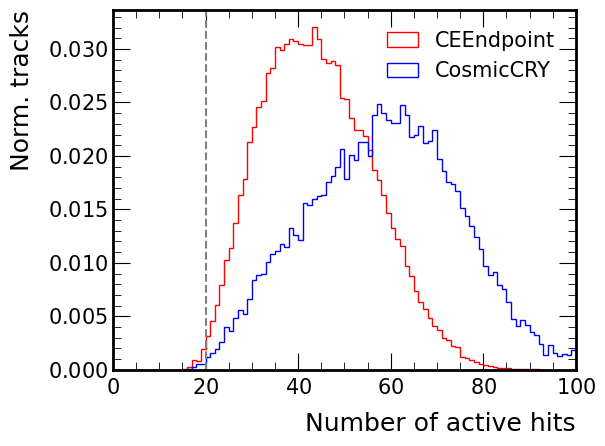

In [12]:
fig, ax = plt.subplots()

plot.plot_1D_overlay(
    {
        "CEEndpoint" : ak.flatten(signal["trk"]["trk.nactive"], axis=None), 
        "CosmicCRY" : ak.flatten(onspill["trk"]["trk.nactive"], axis=None)
    },
    nbins=100,xmin=0,xmax=100,norm_by_area=True,
    show=False,
    ax=ax,
    xlabel="Number of active hits",
    ylabel="Norm. tracks"
)

ax.axvline(20, linestyle="--", color="grey")
plt.tight_layout()
plt.savefig("../../img/comp/h1o_nactive.png", dpi=300)
plt.show()

## R_max

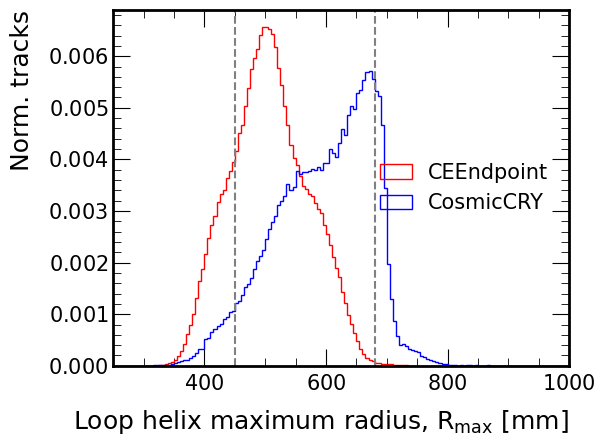

In [13]:
fig, ax = plt.subplots()

plot.plot_1D_overlay(
    {
        "CEEndpoint" : ak.flatten(data_signal["trkfit"]["trksegpars_lh"]["maxr"], axis=None), 
        "CosmicCRY" : ak.flatten(data_onspill["trkfit"]["trksegpars_lh"]["maxr"], axis=None)
    },
    nbins=75*2,xmin=250,xmax=1000,norm_by_area=True,
    show=False,
    ax=ax,
    xlabel=r"Loop helix maximum radius, $R_{\text{max}}$ [mm]",
    ylabel="Norm. tracks"
)

ax.axvline(450, linestyle="--", color="grey")
ax.axvline(680, linestyle="--", color="grey")
plt.tight_layout()
plt.savefig("../../img/comp/h1o_lhrmax.png", dpi=300)
plt.show()

## d_0

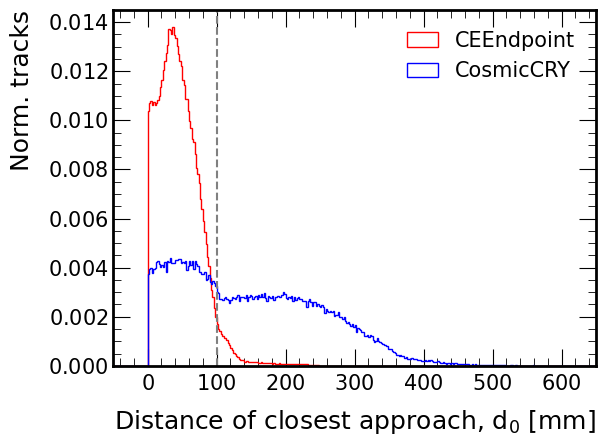

In [14]:
fig, ax = plt.subplots()

plot.plot_1D_overlay(
    {
        "CEEndpoint" : ak.flatten(data_signal["trkfit"]["trksegpars_lh"]["d0"], axis=None), 
        "CosmicCRY" : ak.flatten(data_onspill["trkfit"]["trksegpars_lh"]["d0"], axis=None)
    },
    nbins=350,xmin=-50,xmax=650,norm_by_area=True,
    show=False,
    ax=ax,
    xlabel=r"Distance of closest approach, $d_{0}$ [mm]",
    ylabel="Norm. tracks"
)


ax.axvline(100, linestyle="--", color="grey")
plt.tight_layout()
plt.savefig("../../img/comp/h1o_d0.png", dpi=300)
plt.show()

## tanDip

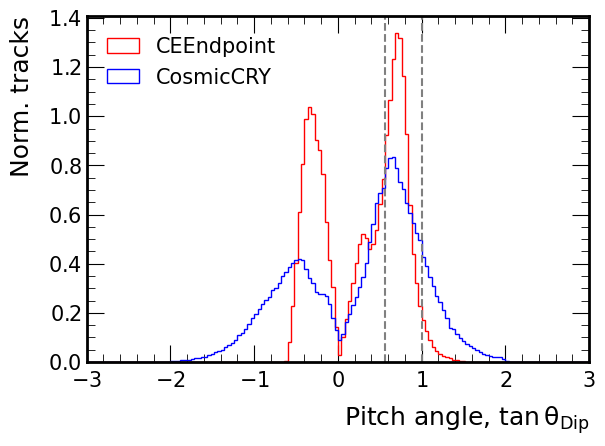

In [15]:
fig, ax = plt.subplots()

plot.plot_1D_overlay(
    {
        "CEEndpoint" : ak.flatten(data_signal["trkfit"]["trksegpars_lh"]["tanDip"], axis=None), 
        "CosmicCRY" : ak.flatten(data_onspill["trkfit"]["trksegpars_lh"]["tanDip"], axis=None)
    },
    nbins=150,xmin=-3,xmax=3,norm_by_area=True,
    show=False,
    ax=ax,
    xlabel=r"Pitch angle, $\tan{\theta_{\text{Dip}}}$",
    ylabel="Norm. tracks"
)


ax.axvline(0.5577350, linestyle="--", color="grey")
ax.axvline(1.0, linestyle="--", color="grey")
plt.tight_layout()
plt.savefig("../../img/comp/h1o_tandip.png", dpi=300)
plt.show()

## d_0 vs mom

In [16]:
help(plot.plot_2D)

Help on method plot_2D in module pyutils.pyplot:

plot_2D(x, y, weights=None, nbins_x=100, xmin=-1.0, xmax=1.0, nbins_y=100, ymin=-1.0, ymax=1.0, title=None, xlabel=None, ylabel=None, zlabel=None, out_path=None, cmap='inferno', dpi=300, log_x=False, log_y=False, log_z=False, colorbar=True, ax=None, show=True) method of pyutils.pyplot.Plot instance
    Plot a 2D histogram from two arrays of the same length.

    Args:
        x (np.ndarray): Array of x-values
        y (np.ndarray): Array of y-values
        weights (np.ndarray, optional): Optional weights for each point
        nbins_x (int): Number of bins in x. Defaults to 100
        xmin (float): Minimum x value. Defaults to -1.0
        xmax (float): Maximum x value. Defaults to 1.0
        nbins_y (int): Number of bins in y. Defaults to 100
        ymin (float): Minimum y value. Defaults to -1.0
        ymax (float): Maximum y value. Defaults to 1.0
        title (str, optional): Plot title
        xlabel (str, optional): X-axis 

In [17]:
# help(vector.get_mag)

[pyvector] ⭐️ Initialised Vector with verbosity = 1
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude


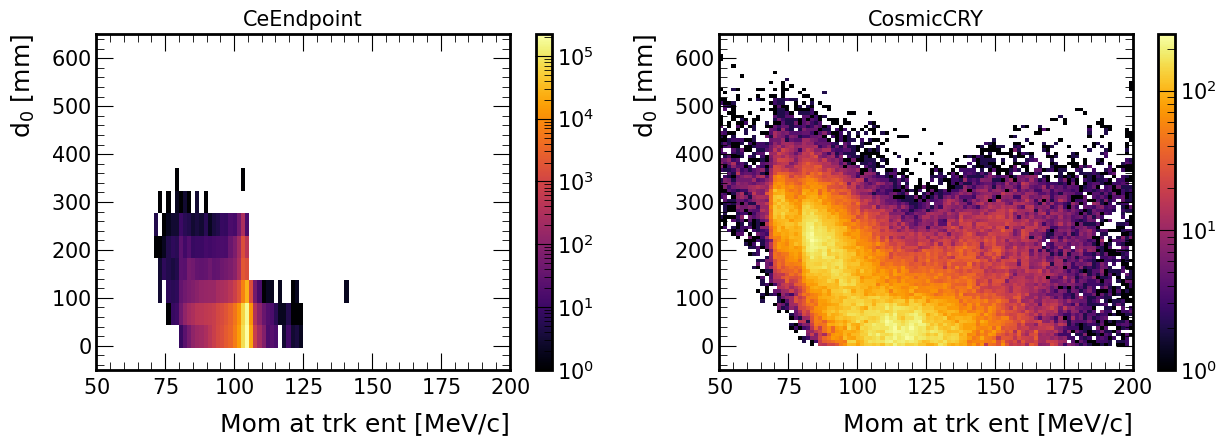

In [18]:
# plot=Plot()
# nhits_signal = ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)
# nhits_background = ak.flatten(background["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)

fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

vector = Vector()

plot.plot_2D(
    x=ak.flatten(vector.get_mag(data_signal["trkfit"]["trksegs"], "mom"), axis=None),
    y=ak.flatten(data_signal["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    nbins_x=100,xmin=50,xmax=200,
    nbins_y=15,ymin=-50,ymax=650,
    ax=ax[0],
    show=False,
    xlabel=r"Mom at trk ent [MeV/c]", 
    ylabel=r"$d_{0}$ [mm]",
    title="CeEndpoint",
    log_z=True
)

plot.plot_2D(
    x=ak.flatten(vector.get_mag(data_onspill["trkfit"]["trksegs"], "mom"), axis=None),
    y=ak.flatten(data_onspill["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    nbins_x=100,xmin=50,xmax=200,
    nbins_y=100,ymin=-50,ymax=650,
    ax=ax[1],
    show=False,
    xlabel=r"Mom at trk ent [MeV/c]", 
    ylabel=r"$d_{0}$ [mm]",
    title="CosmicCRY",
    log_z=True
)

# # ax.axvline(0.5577350, linestyle="--", color="grey")
# ax.axvline(2, linestyle="--", color="grey")
plt.tight_layout()
plt.savefig("../../img/comp/h2_mom_vs_d0.png", dpi=300)
plt.show()


In [19]:
print(list(set(ak.flatten(data_onspill["trkfit"]["trksegs"]["sid"], axis=None))))
print(list(set(ak.flatten(data_signal["trkfit"]["trksegs"]["sid"], axis=None))))

[96, 0, 1, 2, 101, 103, 104, 90, 95]
[0, 1, 2, 96, 101, 103, 104, 90]


In [20]:
help(plot.plot_1D_overlay)

Help on method plot_1D_overlay in module pyutils.pyplot:

plot_1D_overlay(hists_dict, weights=None, nbins=100, xmin=-1.0, xmax=1.0, title=None, xlabel=None, ylabel=None, out_path=None, dpi=300, leg_pos='best', log_x=False, log_y=False, norm_by_area=False, ax=None, show=True) method of pyutils.pyplot.Plot instance
    Overlay multiple 1D histograms from a dictionary of arrays.

    Args:
        hists_dict (Dict[str, np.ndarray]): Dictionary mapping labels to arrays
        weights (List[np.ndarray], optional): List of weight arrays for each histogram
        nbins (int, optional): Number of bins. Defaults to 100
        xmin (float, optional): Minimum x-axis value. Defaults to -1.0
        xmax (float, optional): Maximum x-axis value. Defaults to 1.0
        title (str, optional): Plot title
        xlabel (str, optional): X-axis label
        ylabel (str, optional): Y-axis label
        out_path (str, optional): Path to save the plot
        dpi (int, optional): DPI for saved plot. De

In [21]:
import matplotlib.colors as colors
from matplotlib.ticker import ScalarFormatter

def _scientific_notation(ax, lower_limit=1e-3, upper_limit=1e3, cbar=None): 
    """
    Set scientific notation on axes when appropriate.
    
    Args:
      ax (plt.Axes): Matplotlib axes object
      lower_limit (float): Lower threshold for scientific notation
      upper_limit (float): Upper threshold for scientific notation
      cbar (plt.colorbar.Colorbar, optional): Colorbar object
        
    Note:
      Scientific notation is applied when values are outside the specified limits
    """
    # Convert limits to scilimits format (powers of 10)
    lower_exp = int(np.log10(lower_limit))
    upper_exp = int(np.log10(upper_limit))
    scilimits = (lower_exp, upper_exp)
    
    # Configure x-axis
    if ax.get_xscale() != 'log': 
        ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='x', scilimits=scilimits)
    
    # Configure y-axis
    if ax.get_yscale() != 'log': 
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style='sci', axis='y', scilimits=scilimits)
    
    # Configure colourbar
    if cbar is not None: 
        # Get the colorbar range
        cmin, cmax = cbar.norm.vmin, cbar.norm.vmax
        
        # Check if any values are outside the limits
        if (abs(cmax) >= upper_limit or abs(cmax) <= lower_limit or 
            abs(cmin) >= upper_limit or abs(cmin) <= lower_limit):
            
            cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            cbar.ax.ticklabel_format(style='sci', axis='y', scilimits=scilimits)
                
def plot_2D(
    x,
    y,
    weights=None,
    norm=False,
    nbins_x=100,
    xmin=-1.0,
    xmax=1.0,
    nbins_y=100,
    ymin=-1.0,
    ymax=1.0,
    title=None,
    xlabel=None,
    ylabel=None,
    zlabel=None,
    out_path=None,
    cmap='inferno',
    dpi=300,
    log_x=False,
    log_y=False,
    log_z=False,
    colorbar=True,
    ax=None,
    show=True
    ):

    """
    Modified plotter.plot_2D
    """
    # Ensure numpy arrays
    x = ak.to_numpy(x)
    y = ak.to_numpy(y)

    # Filter out empty entries
    valid_indices = [i for i in range(len(x)) if np.any(x[i]) and np.any(y[i])]
    x = [x[i] for i in valid_indices]
    y = [y[i] for i in valid_indices]

    if weights is not None:
        weights = [weights[i] for i in valid_indices]

    # Validate inputs
    if len(x) == 0 or len(y) == 0:
        self.logger.log("Input arrays are empty", "error")
        return None
    if len(x) != len(y):
        self.logger.log("Input arrays have different lengths", "error")
        return None
    
    # Create or use provided axes
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots()
        new_fig = True
    
    # Create 2D histogram
    hist, _, _ = np.histogram2d(
        x, y,
        bins=[nbins_x, nbins_y],
        range=[[xmin, xmax], [ymin, ymax]],
        weights=weights,
        density=norm
    )

    # Set up normalisation
    if log_z:
        norm_z = colors.LogNorm(vmin=1, vmax=np.max(hist))
    else:
        norm_z = colors.Normalize(vmin=np.min(hist), vmax=np.max(hist))
    
    # Plot the 2D histogram
    im = ax.imshow(
        hist.T,
        cmap=cmap,
        extent=[xmin, xmax, ymin, ymax],
        aspect='auto',
        origin='lower',
        norm=norm_z
    )

    # Configure axes scales
    if log_x:
        ax.set_xscale('log')
    if log_y:
        ax.set_yscale('log')

    # Add colorbar
    cbar = None
    if colorbar:
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label(zlabel)

    # Set labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Scientific notation
    _scientific_notation(ax, cbar=cbar)

    if new_fig:
        # Draw
        plt.tight_layout()

    # Save if path provided
    if out_path:
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
        self.logger.log(f"Wrote:\n\t{out_path}", "success")

    # Show if requested
    if show:
        plt.show()

[pyvector] ⭐️ Initialised Vector with verbosity = 1
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Got 'mom' magnitude


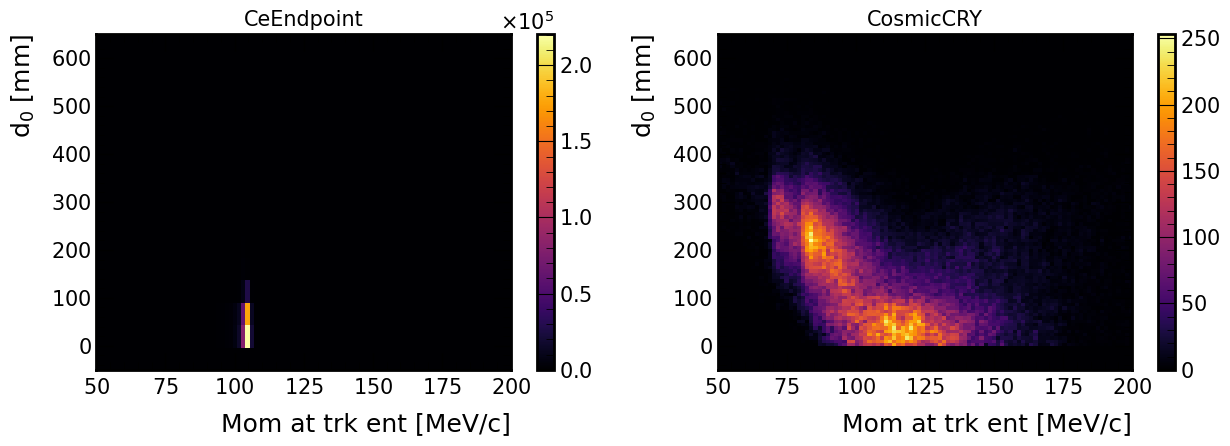

In [22]:
# plot=Plot()
# nhits_signal = ak.flatten(signal["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)
# nhits_background = ak.flatten(background["trkfit"]["trksegpars_lh"]["tanDip"],axis=None)

fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

vector = Vector()

plot_2D(
    x=ak.flatten(vector.get_mag(data_signal["trkfit"]["trksegs"], "mom"), axis=None),
    y=ak.flatten(data_signal["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    nbins_x=100,xmin=50,xmax=200,
    nbins_y=15,ymin=-50,ymax=650,
    ax=ax[0],
    show=False,
    xlabel=r"Mom at trk ent [MeV/c]", 
    ylabel=r"$d_{0}$ [mm]",
    title="CeEndpoint",
    # norm=True
)

plot_2D(
    x=ak.flatten(vector.get_mag(data_onspill["trkfit"]["trksegs"], "mom"), axis=None),
    y=ak.flatten(data_onspill["trkfit"]["trksegpars_lh"]["d0"], axis=None),
    nbins_x=100,xmin=50,xmax=200,
    nbins_y=100,ymin=-50,ymax=650,
    ax=ax[1],
    show=False,
    xlabel=r"Mom at trk ent [MeV/c]", 
    ylabel=r"$d_{0}$ [mm]",
    title="CosmicCRY",
    # norm=True
    # log_z=True
)

# # ax.axvline(0.5577350, linestyle="--", color="grey")
# ax.axvline(2, linestyle="--", color="grey")
plt.tight_layout()
plt.savefig("../../img/comp/h2_mom_vs_d0.png", dpi=300)
plt.show()